In [1]:
# loading parameters

Ne = 10 # must be even
number_of_mito_in_cell = 3
percent_of_recombinating_mito = 0.8
number_of_recombinations = 3
recombination_len = 2
seq_len = 10
percent_of_recombinating_sp = 0.1
mutations_per_gen = 0
number_of_generations = 100



def status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations):
    print("Recieved parameters: \n \t Ne: {Ne}, \n \t number_of_mito_in_cell: {number_of_mito_in_cell}, \n \t percent_of_recombinating_mito: {percent_of_recombinating_mito}, \n \t number_of_recombinations: {number_of_recombinations}, \n \t recombination_len: {recombination_len}, \n \t seq_len: {seq_len}, \n \t percent_of_recombinating_sp: {percent_of_recombinating_sp}, \n \t mutations_per_gen: {mutations_per_gen}, \n \t number_of_generations: {number_of_generations}".format(Ne = Ne,
number_of_mito_in_cell = number_of_mito_in_cell,
percent_of_recombinating_mito = percent_of_recombinating_mito,
number_of_recombinations = number_of_recombinations,
recombination_len = recombination_len,
seq_len = seq_len,
percent_of_recombinating_sp = percent_of_recombinating_sp,
mutations_per_gen = mutations_per_gen,
number_of_generations = number_of_generations))

status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)  

Recieved parameters: 
 	 Ne: 10, 
 	 number_of_mito_in_cell: 3, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 3, 
 	 recombination_len: 2, 
 	 seq_len: 10, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 100


In [2]:
# modules
from IPython.core.display import display, HTML
display(HTML("<style>.output_wrapper, .output {    height:auto !important;max-height:1000px;  /* your desired max-height here */}.output_scroll {    box-shadow:none !important;    webkit-box-shadow:none !important;}</style>"))

import random
from random import randrange 
import os
import re
import sys
import argparse
import subprocess
from time import clock
import pandas as pd
import numpy as np
from itertools import groupby
import itertools
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, Gapped
from Bio import SeqIO
import os
from Bio import Phylo
from Bio.Align.Applications import ClustalwCommandline
from sys import argv
from Bio import AlignIO
from time import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from scipy import stats

In [3]:
# creating a model

def an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,nuc_mode=None,population_mode=None):
    #status(Ne,mito_q_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)
    
    if nuc_mode == "nuc":
        seed = "ATGC"
    else:
        seed = "1234"
    
    
    # creating mutation function
    def mutate(seq, mutations_per_gen, mode=None):
        #print(seq)
        seq_cp = seq.copy()
        if mode == "new_population":
            mutations_per_gen = mutations_per_gen
        else:
            mutations_per_gen = mutations_per_gen
        for i in range(mutations_per_gen):
            mutation_site = randrange(len(seq_cp))
            #print(mutation_site)
            seq_cp[mutation_site] = random.choice(seed)     
        #print(seq_cp)
        return seq_cp    
        
    if population_mode == "first":  
        # creating seqs
        seq = [random.choice(seed) for i in range(seq_len)]
        #seq = list("ACAGTCCCATTCGACGAAGGATCATTGTAGAATTCCTATCTACTTTGGCCGCAGAGTTGTGTCTGTGGTCTTGCGCGTGTATTCGTCCGGGAATCGCTATCTAGTGCAGATCATCCGCGGGAAGCACCACGCAAAGTGTAGATTCGGACAGGCACGTACTTTACTATACTCCTGTATACTTGCCCGGGTGCGTCGTATTCTAAGCGGTCAACGGAAACCAGCGCTCTCGTAAATGAGACTACAGGTAGGCCTCGTATTTGCCAGACCTACTAGACCTAGCTACCACGTTCGTTCGATCTCTTCCGAGTTAATTATACGCACGTAACCCTAGGGTCGGCGCATTATCATAACTCCGTAATACCGGCGGGCACTCCCGCCTTAGCCGCCGCCCAGTAGATAAACTGCAGGTTCAACGAATCGACTATCTGGCCACATTGACGAGGAGCCGGTGGTTGTTTTCATGCGCAGGTTATGGTACGTCGGACCTCTGCCATGGCATG")
        #print("".join(seq))
        population = [mutate(seq, mutations_per_gen, "new_population") for x in range(Ne)]
        #print(" ")
        #for i in population:
            #print("".join(i))
        #print(" ")
    else:
        population = population_mode
    
    # breeding
    selected_list = []
    number_of_species = int(percent_of_recombinating_sp * len(population))
    if number_of_species%2 != 0:
        #print("the number of selected species was", number_of_species)
        number_of_species += 1
    #print("the number of selected species is", number_of_species)
        
    for i in range(number_of_species):
        p = randrange(len(population))
        #print(p)
        selected_list.append(population.pop(p))
    
    #print(" ")
    #print("population length is", len(population))
    #print("selected list length is", len(selected_list))
    #print(" ")
    
    # crossingover
    
    def crossingover(seq_1, seq_2, number_of_recombinations, recombination_len):
        if number_of_recombinations or recombination_len > 0:    
            while recombination_len > (len(seq_1) - recombination_len)/number_of_recombinations:
                #print(recombination_len, len(seq_1)/number_of_recombinations)
                recombination_len -= 1
                #print("recombination length now is", recombination_len)
            #print("recombination length is", recombination_len)
            
            #positions = [randrange(len(seq_1) - recombination_len) for x in range(number_of_recombinations)]
            #print(positions)
            
            
            def partition(seq_in1, seq_in2, recombination_len, number_of_recombinations, ind):
                #print("".join(seq_in1))
                if ind >= number_of_recombinations:
                    #print(seq_in1, seq_in2)
                    return seq_in1, seq_in2
                if len(seq_in1) - recombination_len <= 0:
                    #print(seq_in1, seq_in2)
                    return seq_in1, seq_in2
                             
                position = randrange(len(seq_in1) - recombination_len)
                #print(position)
                out_seq1 = itertools.chain.from_iterable([partition(seq_in1[:position], seq_in2[:position], recombination_len, number_of_recombinations, ind + 1)[0]] + [partition(seq_in1[position:], seq_in2[position:], recombination_len, number_of_recombinations, ind + 1)[0]])
                out_seq2 = itertools.chain.from_iterable([partition(seq_in1[:position], seq_in2[:position], recombination_len, number_of_recombinations, ind + 1)[1]] + [partition(seq_in1[position:], seq_in2[position:], recombination_len, number_of_recombinations, ind + 1)[1]])
                
                #print("".join(out_seq))
                #print(out_seq1, out_seq2)
                return out_seq1, out_seq2
            
            #print("seq 1", "".join(seq_1))
            #print("seq 2", "".join(seq_2))
            
            parts_1, parts_2 = partition(seq_1, seq_2, recombination_len, number_of_recombinations, 0)
            
            #print("parts_1 1", parts_1)
            #print("parts_2 2", parts_2)
            
            seq_1 = []
            seq_2 = []
            ind = True
            for i, j in zip(parts_1, parts_2):
                #print(i, j)
                if ind == True:
                    seq_1.append(i)
                    seq_2.append(j)
                    ind = False
                    #print(seq_1)
                    continue
                if ind == False:
                    seq_1.append(j)
                    seq_2.append(i)
                    ind = True
                    #print(seq_1)
                    continue
            
            seq_1 = list(itertools.chain.from_iterable(seq_1))
            seq_2 = list(itertools.chain.from_iterable(seq_2))
            #print("unite", seq_1, seq_2)
                
            #print("cross out", seq_1, "\n", seq_2) 
            return seq_1, seq_2
        
        
    
    # multipy selected seqs
    
    def multiply_seqs(result, work_list, mutations_per_gen, number_of_recombinations, recombination_len, number_of_mito_in_cell, mode=None):
        for i, j in zip(work_list[0::2], work_list[1::2]):
            mito_list_i = []
            mito_list_j = []
            for k in range(number_of_mito_in_cell):
                mito_list_i.append(i)
                mito_list_j.append(j)
                #print(" ")
                #print("".join(i))
                i = mutate(i, mutations_per_gen)
                #print("".join(i))
                #print(" ")
                #print("".join(j))
                j = mutate(j, mutations_per_gen)
                #print("".join(j))
            i = random.choice(mito_list_i)   
            j = random.choice(mito_list_j)   
            if mode == "crossingover_it":
                #print(" ")
                #print("".join(i))
                #print("".join(j))
                
                i, j = crossingover(i, j, number_of_recombinations, recombination_len)
                
                #print(" ")
                #print(i)
                #print(j)
                
            new_born_seq = random.choice([i,j])
            result.append(new_born_seq)
            result.append(mutate(new_born_seq, mutations_per_gen))
            #result.append("".join(new_born_seq))
            #result.append("".join(mutate(new_born_seq, mutations_per_gen)))
            
    
    
    result = []
    multiply_seqs(result, selected_list, mutations_per_gen, number_of_recombinations, recombination_len, number_of_mito_in_cell, "crossingover_it")
    multiply_seqs(result, population, mutations_per_gen, number_of_recombinations, recombination_len, number_of_mito_in_cell)
    
    #print(len(result))
    #print(result)
    # mutate selected seqs
    return result


def decoder(result):
    
    def make_it_in_nucl(seq):
        dic = {1:"A",2:"T",3:"G",4:"C"}
        for i in seq:
            seq[j] = dic(int(seq[j]))
            
    for i in result:
        result[i] = make_it_in_nucl(result[i])
        
    return result


start = clock()
step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc","first")
for i in range(number_of_generations):
    
    step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc",step)
end = clock()
    
    
for i in step:
    print("".join(i))
print(" ")

print(round(end - start,5), "seconds")

ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
ATACCTCTAA
 
0.01791 seconds


In [4]:
align = MultipleSeqAlignment([], Gapped(IUPAC.unambiguous_dna, "-"))
for i in range(len(step)):
    align.add_sequence(str(i), "".join(step[i]))


In [25]:
def count_dict(mystring):
    d = {}
    for w in mystring: 
        d[w] = mystring.count(w)
    print(d.values(), min(d.values())/len(mystring))
    if min(d.values())/len(mystring) < 0.25:
        return -1
    else:
        return 1

def slice_maker(step):
    for i in range(len(step[0])):
        string = ""
        for j in range(len(step)):
            string += step[j][i]
        print(string)
        if count_dict(string) == -1:
            for j in range(len(align)):
                step[j][i] = "N"
        
slice_maker(step)

step[3][5] = "N"
step

AAAAAAAAAA
dict_values([10]) 1.0
TTTTTTTTTT
dict_values([10]) 1.0
AAAAAAAAAA
dict_values([10]) 1.0
CCCCCCCCCC
dict_values([10]) 1.0
CCCCCCCCCC
dict_values([10]) 1.0
TTTNTTTTTT
dict_values([9, 1]) 0.1
CCCCCCCCCC
dict_values([10]) 1.0
TTTTTTTTTT
dict_values([10]) 1.0
AAAAAAAAAA
dict_values([10]) 1.0
AAAAAAAAAA
dict_values([10]) 1.0


[['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A'],
 ['A', 'T', 'A', 'C', 'C', 'N', 'C', 'T', 'A', 'A']]

In [32]:
align = MultipleSeqAlignment([], Gapped(IUPAC.unambiguous_dna, "-"))
for i in range(len(step)):
    align.add_sequence(str(i), "".join(step[i]))

#for i in range(30):
#    align.add_sequence(str(i), "".join(step[i]))

#print(align)
#print(align.format("fasta"))

#for record in align:
#    print(record.id)
#    print(record.seq)

#align.get_alignment_length()

from Bio.Align.Applications import ClustalwCommandline
SeqIO.write(align, "align.fasta", "fasta" )

!clustalw align.fasta






 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence format is Pearson
Sequence 1: 0             10 bp
Sequence 2: 1             10 bp
Sequence 3: 2             10 bp
Sequence 4: 3             10 bp
Sequence 5: 4             10 bp
Sequence 6: 5             10 bp
Sequence 7: 6             10 bp
Sequence 8: 7             10 bp
Sequence 9: 8             10 bp
Sequence 10: 9             10 bp
Start of Pairwise alignments
Aligning...

Sequences (1:2) Aligned. Score:  100
Sequences (1:3) Aligned. Score:  40
Sequences (1:4) Aligned. Score:  40
Sequences (1:5) Aligned. Score:  40
Sequences (1:6) Aligned. Score:  70
Sequences (1:7) Aligned. Score:  20
Sequences (1:8) Aligned. Score:  20
Sequences (1:9) Aligned. Score:  30
Sequences (1:10) Aligned. Score:  30
Sequences (2:3) Aligned. Score:  40
Sequences (2:4) Aligned. Score:  40
Sequences (2:5) Aligned. Score:  40
Sequences (2:6) Aligned. Score:  70
Sequences (2:7) Aligned. Score:  20
Sequences (2:8) Aligned. Score:  20
Sequences (2:9) Align

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.11094)
            Clade(branch_length=0.08542)
                Clade(branch_length=0.27812)
                    Clade(branch_length=0.0, name='0')
                    Clade(branch_length=0.0, name='1')
                Clade(branch_length=0.14687)
                    Clade(branch_length=0.27)
                        Clade(branch_length=0.05, name='6')
                        Clade(branch_length=0.05, name='7')
                    Clade(branch_length=0.28)
                        Clade(branch_length=0.05714, name='8')
                        Clade(branch_length=0.04286, name='9')
            Clade(branch_length=0.02708, name='5')
        Clade(branch_length=0.08594)
            Clade(branch_length=0.00156, name='2')
            Clade(branch_length=0.09844, name='3')
        Clade(branch_length=0.01406, name='4')


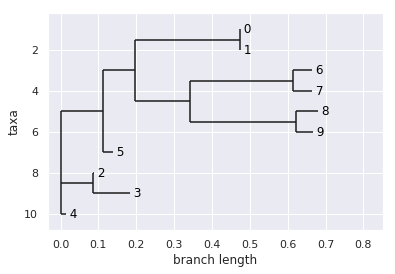

In [19]:
tree = Phylo.read('align.dnd', 'newick')
print(tree)
#tree.ladderize()
Phylo.draw(tree)

In [157]:
Phylo.draw_ascii(tree)

                                                                  _ 0
                       __________________________________________|
                      |                                          | 1
        ______________|
       |              |                                             , 8
       |              |_____________________________________________|
       |                                                            | 9
   ____|
  |    |                                                        , 2
  |    |             ___________________________________________|
  |    |            |                                           | 3
  |    |            |
  |    |____________|                                            , 10
  |                 |                   _________________________|
  |                 |                  |                         | 11
  |                 |__________________|
  |                                    |                                 , 

In [44]:
def format_frequencies(frequencies):
    return ', '.join(['%s: %.2f' % (base, frequencies[base])
                      for base in frequencies])


def draw(discrete_probdist):
    limit = 0
    r = random.random()
    for value in discrete_probdist:
        limit += discrete_probdist[value]
        if r < limit:
            return value
      
def create_markov_chain():
    markov_chain = {}
    for from_base in '1234':
           slice_points = sorted(
               [0] + [random.random()for i in range(3)] + [1])
           transition_probabilities = \
               [slice_points[i+1] - slice_points[i] for i in range(4)]
           markov_chain[from_base] = {base: p for base, p
                         in zip('1234', transition_probabilities)}
    return markov_chain    
    
        
def mutate_via_markov_chain(dna, markov_chain):
    dna_list = list(dna)
    mutation_site = random.randint(0, len(dna_list) - 1)
    from_base = dna[mutation_site]
    to_base = draw(markov_chain[from_base])
    dna_list[mutation_site] = to_base
    return ''.join(dna_list)


dna = [random.choice('1234') for _ in range(seq_len)]
print(dna)
mc = create_markov_chain()
import pprint
nmutations = 1
for i in range(nmutations):
    dna = mutate_via_markov_chain(dna, mc)
print(dna)

In [20]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
import numpy as np

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
dm
print(dm)


0	0
1	0.0	0
2	0.4	0.4	0
3	0.4	0.4	0.09999999999999998	0
4	0.4	0.4	0.09999999999999998	0.19999999999999996	0
5	0.30000000000000004	0.30000000000000004	0.19999999999999996	0.30000000000000004	0.09999999999999998	0
6	0.5	0.5	0.7	0.7	0.7	0.7	0
7	0.5	0.5	0.7	0.7	0.7	0.7	0.09999999999999998	0
8	0.6	0.6	0.9	0.9	0.9	0.9	0.6	0.5	0
9	0.6	0.6	0.9	0.9	0.9	0.9	0.7	0.6	0.09999999999999998	0
	0	1	2	3	4	5	6	7	8	9


In [21]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
import pandas as pd
from skbio import DNA, TabularMSA
import skbio.io
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide

In [22]:
from numpy import mean
from functools import partial

def cluster(seqs, similarity_threshold, cluster_fn, aligner=local_pairwise_align_ssw, verbose=False):
    clusters = []
    num_alignments = 0
    for query_seq in seqs:
        if verbose: print(query_seq.metadata['id'])
        clustered = False
        for i, cluster in enumerate(clusters, start=1):
            if verbose: print(" OTU %d" % i)
            clustered, alignment_results = cluster_fn(
                query_seq, cluster, similarity_threshold, aligner, verbose=verbose)
            num_alignments += len(alignment_results)
            if clustered:
                break
        if clustered:
            for n, s in alignment_results:
                cluster.add_node(query_seq.metadata['id'], seq=query_seq)
                cluster.add_edge(query_seq.metadata['id'], n, percent_similarity=s)
                # this is very inefficient, but need a way to retain order
                # for centroid clustering.
                # will come back to this...
                cluster.graph['node-order'].append(query_seq.metadata['id'])
            if verbose: print("Added to OTU")
        else:
            # create a new cluster containing only this node
            new_cluster = nx.Graph(id="OTU %d" % (len(clusters) + 1))
            new_cluster.add_node(query_seq.metadata['id'], seq=query_seq)
            # this is very inefficient, but need a way to retain order
            # for centroid clustering.
            # will come back to this...
            new_cluster.graph['node-order'] = [query_seq.metadata['id']]
            clusters.append(new_cluster)
            if verbose: print("Created OTU")
    return clusters, num_alignments


def furthest_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    for node in list(cluster.nodes()):
        aln, _, _ = aligner(seq, cluster.node[node]['seq'])
        percent_similarity = 1. - aln[0].distance(aln[1])
        alignment_results.append((node, percent_similarity))
        if verbose: print("  ", node, percent_similarity)
        if percent_similarity < similarity_threshold:
            return False, alignment_results
    return True, alignment_results

def nearest_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    for node in list(cluster.nodes()):
        aln, _, _ = aligner(seq, cluster.node[node]['seq'])
        percent_similarity = 1. - aln[0].distance(aln[1])
        alignment_results.append((node, percent_similarity))
        if verbose: print(" ", node, percent_similarity)
        if percent_similarity >= similarity_threshold:
            return True, alignment_results
    return False, alignment_results

def centroid_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    centroid_node = cluster.graph['node-order'][0]
    aln, _, _ = aligner(seq, cluster.node[centroid_node]['seq'])
    percent_similarity = 1. - aln[0].distance(aln[1])
    if verbose: print(" ", centroid_node, percent_similarity)
    alignment_results.append((centroid_node, percent_similarity))
    return percent_similarity >= similarity_threshold, alignment_results

def show_clusters(clusters, print_clusters=True, plot_clusters=True, plot_labels=False):
    G = nx.Graph()
    for c in clusters:
        G = nx.union(G, c)
        if print_clusters: print("%s: %s" % (c.graph['id'], [s for s in c.graph['node-order']]))
    if plot_clusters:
        pos=nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color='w')
        if G.number_of_edges() > 0:
            nx.draw_networkx_edges(G, pos)
        if plot_labels: nx.draw_networkx_labels(G, pos, labels={d:G.node[d]['seq'].metadata['id'] for d in G.nodes()})
        _ = plt.axis('off')

# For our toy example, we want our sequences to align from beginning to end
# so we'll penalize terminal gaps.
global_pairwise_align_nucleotide = partial(global_pairwise_align_nucleotide, penalize_terminal_gaps=True)

In [24]:
align = []
for i in range(10):
    align.append( DNA(str("".join(step[i])), {'id': "s"+str(i)}) )


align


[DNA
 --------------------------
 Metadata:
     'id': 's0'
 Stats:
     length: 10
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 40.00%
 --------------------------
 0 AGATTTAGGC, DNA
 --------------------------
 Metadata:
     'id': 's1'
 Stats:
     length: 10
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 40.00%
 --------------------------
 0 AGATTTAGGC, DNA
 --------------------------
 Metadata:
     'id': 's2'
 Stats:
     length: 10
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 70.00%
 --------------------------
 0 ACCTGCAGGC, DNA
 --------------------------
 Metadata:
     'id': 's3'
 Stats:
     length: 10
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 70.00%
 --------------------------
 0 ACGTGCAGGC, DNA
 --------------------------
 Metadata:
     'id': 's4'
 Stats:
     length: 10
     has gaps: False

In [25]:
al = AlignIO.read("Oligoryzomys_destructor_destructor_CYTB[gene].fasta.aligned.fasta", "fasta" )
al
align = []
for i in range(10):
    align.append( DNA(str("".join(al[i])), {'id': "s"+str(i)}) )


align

[DNA
 ---------------------------------------------------------------------
 Metadata:
     'id': 's0'
 Stats:
     length: 801
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 40.57%
 ---------------------------------------------------------------------
 0   ATGACAATTA TACGAAAAAA TCATCCACTA CTTAAAATTA TTAATCACTC ATTCATTGAC
 60  CTACCCACCC CATCCAACAT CTCAGCATGA TGAAATTTTG GCTCACTATT AGGAATCTGC
 ...
 720 TTTTTAGTAT TATTTTTCCC AGATGTTCTC GGAGACCCCG ACAATTATAC ACCAGCAAAC
 780 CCACTCAACA CCCCAGCACA C, DNA
 ---------------------------------------------------------------------
 Metadata:
     'id': 's1'
 Stats:
     length: 801
     has gaps: False
     has degenerates: False
     has definites: True
     GC-content: 40.57%
 ---------------------------------------------------------------------
 0   ATGACAATTA TACGAAAAAA TCATCCACTA CTTAAAATTA TTAATCACTC ATTCATTGAC
 60  CTACCCACCC CATCCAACAT CTCAGCATGA TGAAATTTTG GCTCACTATT AGGAATCTGC
 ...
 720 TTTTTAG

In [27]:
clusters, num_alignments = cluster(align, 0.70,
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

s0
Created OTU
s1
 OTU 1


/home/pavel/anaconda3/lib/python3.6/site-packages/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


KeyboardInterrupt: 

In [28]:
show_clusters(clusters)

NameError: name 'clusters' is not defined

In [29]:
clusterlist = []
for c in clusters:
    if True: 
        print("%s: %s" % (c.graph['id'], [s for s in c.graph['node-order']]))
        l = random.sample([s for s in c.graph['node-order']],1)
        clusterlist.append(l[0])
print(clusterlist)

NameError: name 'clusters' is not defined

In [11]:
clusters, num_alignments = cluster(align, 0.70, furthest_neighbor)
show_clusters(clusters, plot_clusters=True, plot_labels=True)

NameError: name 'cluster' is not defined

In [33]:
import sys
import os
from Bio import AlignIO
from functools import reduce
 
s_bases = ('A', 'C', 'G', 'T')
d_bases = ('R', 'Y', 'S', 'W', 'K', 'M', 'N')
bases = s_bases + d_bases
 
deg_map = {'A':('A','A'),'C':('C','C'), 'G':('G','G'), 'T':('T','T'), 'R':('A','G'), 'Y':('C','T'), 'S':('C','G'), 'W':('A','T'), 'K':('G','T'), 'M':('A','C')}
 
 
inname = os.path.basename(sys.argv[1])
 
colnames = [sq.id for sq in align]
colnames = ['file', 'pos'] + colnames
print('\t'.join(colnames))
 
cutoff = 0.5
for i in range(align.get_alignment_length()):
    col = align[:,i]
    col = col.upper()
    col = col.replace('-', 'N') 
 
    base_count = {b:col.count(b) for b in bases}
    del base_count['N']
 
    if sum(base_count.values()) > len(col)*cutoff:
 
        genotypes = sorted(base_count.items(), key=lambda x:-x[1])
        genotypes = [b for b in genotypes if b[1] > 0]
 
        ref = genotypes[0][0]
 
        if ref in d_bases:
            ref = deg_map[ref][0]
 
        allel = [deg_map[b[0]] for b in genotypes]
        allel = reduce(lambda x,y: x+y, allel)
        allel = list(set(allel))
 
        j = allel.index(ref)
        allel[0], allel[j] = allel[j], allel[0]
 
        allel_code = {b:k for k, b in enumerate(allel)}
 
        if len(allel) > 1:
            snps = [inname, '%d'%(i+1), ref, ','.join(allel[1:])]
            for s in col:
                if not s == 'N':
                    code = [allel_code[a] for a in deg_map[s]]
                    code = sorted(code)
                    snps.append('%d/%d' % (code[0], code[1]))
 
                else:
                    snps.append('-/-')
            print('\t'.join(snps))

file	pos	0	1	2	3	4	5	6	7	8	9
-f	2	C	T,G,A	2/2	2/2	0/0	0/0	0/0	2/2	3/3	3/3	1/1	1/1
-f	3	A	G,C	0/0	0/0	2/2	1/1	2/2	2/2	0/0	0/0	0/0	0/0
-f	4	T	C,G	0/0	0/0	0/0	0/0	0/0	0/0	1/1	2/2	2/2	2/2
-f	5	T	G,A	0/0	0/0	1/1	1/1	2/2	2/2	0/0	0/0	0/0	0/0
-f	6	C	T,A	1/1	1/1	0/0	0/0	0/0	0/0	2/2	2/2	1/1	1/1
-f	7	A	G	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	1/1	1/1
-f	8	G	T,A	0/0	0/0	0/0	0/0	0/0	0/0	1/1	1/1	1/1	2/2
-f	9	G	C	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	1/1	1/1
-f	10	C	G,A	0/0	0/0	0/0	0/0	0/0	0/0	2/2	2/2	1/1	1/1


In [4]:
# -------------------------LD calculation---------------------------
round_ = 4  # The round parameter!
h = 0.25 #float(argv[3])  # The mask parameter!
is_circle = "no"  # circle mode 
print("Default parameters: ", "mask-", h, " circle mode-", is_circle)

def slice_module(slice_number, align_slice, slice_id_dic):   # It takes a slice bar os sequences and write in to the out_file
    align_slice = align_slice.upper()
    A = align_slice.count("A")
    T = align_slice.count("T")
    G = align_slice.count("G")
    C = align_slice.count("C")
    counter_A_pr = round(float(align_slice.count("A") / len(align_slice)), round_)
    counter_T_pr = round(float(align_slice.count("T") / len(align_slice)), round_)
    counter_G_pr = round(float(align_slice.count("G") / len(align_slice)), round_)
    counter_C_pr = round(float(align_slice.count("C") / len(align_slice)), round_)
    counter_N_pr = round(float(align_slice.count("N") / len(align_slice)), round_)
    counter__pr = round(float(align_slice.count("-") / len(align_slice)), round_)
    if ((counter_A_pr or counter_T_pr or counter_G_pr or counter_C_pr or counter_N_pr or counter__pr) == 1) or (counter_N_pr or counter__pr != 0):
        return 0
    else:
        if A+T == len(align_slice) or A+G == len(align_slice) or A+C == len(align_slice) or T+G == len(align_slice) or T+C == len(align_slice) or G+C == len(align_slice):
            if min(counter_A_pr, counter_T_pr) > h or min(counter_A_pr, counter_G_pr) > h or min(counter_A_pr, counter_C_pr) > h or min(counter_T_pr, counter_G_pr) > h or min(counter_T_pr, counter_C_pr) > h or min(counter_G_pr, counter_C_pr) > h:
                slice_id_dic[slice_number] = align_slice  # Making a dict with seqs and keys
        return 1


def nuc_identification_module(line):  # Looking for nuc and nuc% in line
    array = list(line)
    result = {i: array.count(i) for i in array};
    return result


def duplet_compute_module(duplet_list, A, B):
    A_keys = []
    B_keys = []
    for key in A.keys():
        A_keys = A_keys + [key]
    for key in B.keys():
        B_keys = B_keys + [key]

    p1 = round(A[A_keys[0]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    p2 = round(A[A_keys[1]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    q1 = round(B[B_keys[0]]/(B[B_keys[0]] + B[B_keys[1]]), round_)
    q2 = round(B[B_keys[1]]/(B[B_keys[0]] + B[B_keys[1]]), round_)

    p1q1 = str(A_keys[0]) + str(B_keys[0])
    p1q2 = str(A_keys[0]) + str(B_keys[1])
    p2q1 = str(A_keys[1]) + str(B_keys[0])
    p2q2 = str(A_keys[1]) + str(B_keys[1])

    counter_p1q1_pr = round(float(duplet_list.count(p1q1) / len(duplet_list)), round_)
    counter_p1q2_pr = round(float(duplet_list.count(p1q2) / len(duplet_list)), round_)
    counter_p2q1_pr = round(float(duplet_list.count(p2q1) / len(duplet_list)), round_)
    counter_p2q2_pr = round(float(duplet_list.count(p2q2) / len(duplet_list)), round_)
    return counter_p1q1_pr, counter_p1q2_pr, counter_p2q1_pr, counter_p2q2_pr, p1, p2, q1, q2


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or             isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())



def LD_calculation(alignment, percent_of_recombinating_sp):            
    # ---------------------------------Extracting file-----------------------------
       
    #in_file = open(in_f, "r")   # It must be a alignment with equal lengths of sequences
    
    # -------------------------------Modules-----------------------------------------
    

    #alignment = AlignIO.read(in_f, "clustal")  # Importing all alignments from in file
    #in_file.close()
    
    
    align_slice = ''
    slice_id_dic = {}
    
    genome_size = len(alignment[0, :])
    for slice_number in range(genome_size):  # Taking a nucleotide from each bar/slice in alignment and from each sequence. For nuc in range of length of seq
        for seq in range(len(alignment)):  # For seq from all seqs
            align_slice = align_slice + str(alignment[seq, slice_number])  # Making slices
        a = slice_module(slice_number, align_slice, slice_id_dic)  # Collecting it and putting in the slice_module
        align_slice = ''                    
        
    
        
    #LD_out_file = open("LD.txt", "w")
    #LD_out_file.write("Len" + "\t" + "LD" + "\n")
    
    #r2_out_file = open("r2.txt", "w")
    #r2_out_file.write("Len" + "\t" + "r2" + "\n")
    
    
    Len_list = []
    LD_list = []
    r2_list = []
    for key in list(slice_id_dic):  # For keys in dict
        one = slice_id_dic[key]  # Retrieving a slice
        for q in list(slice_id_dic):
            if key < q:  # if we want to count for a half
                if is_circle == "yes":
                    summ = min(abs(int(q) - int(key)), genome_size - abs(int(key) - int(q)))  # Calculating the distance
                if is_circle == "no":
                    summ = abs(int(q) - int(key))
                two = slice_id_dic[q]
                line1 = one.strip()
                line2 = two.strip()
                A = nuc_identification_module(line1)
                B = nuc_identification_module(line2)
    
                duplet_list = []
                for i in range(len(line1)):
                    duplet_list = duplet_list + [line1[i] + line2[i]]
                AB = duplet_compute_module(duplet_list, A, B)
                LD = AB[0]*AB[3] - AB[1]*AB[2]    # D and LD formula
                if LD >= 0:
                    LD_out = round(LD/(min(AB[4]*AB[7], AB[5]*AB[6])), round_)
                if LD < 0:
                    LD_out = round(LD/(max(-AB[4]*AB[6], -AB[5]*AB[7])), round_)
    
                #LD_out_file.write(str(summ) + "\t" + str(LD_out) + "\n")
    
                r = round((LD**2)/(AB[4]*AB[5]*AB[6]*AB[7]), round_)
                #r2_out_file.write(str(summ) + "\t" + str(r) + "\n")
                Len_list.append(summ)
                LD_list.append(LD_out)
                r2_list.append(r)
                
    #LD_out_file.close() 
    #r2_out_file.close() 

    print("Len of LD list is",len(LD_list))
    # -------------------------Visualization---------------------------
    df = pd.DataFrame(dict(Length_between_SNPs=np.array(Len_list), LD=np.array(LD_list), R2=np.array(r2_list)))

    # logistic regression
    #fig = sns.lmplot(x="Length_between_SNPs", y="LD", data=df)
    #fig = sns.lmplot(x="Length_between_SNPs", y="LD", data=df, robust=True, ci=None, scatter_kws={"s": 80});
    #fig = fig.fig 
    #fig.suptitle("LD plot with {i} percent of recombination".format(i=str(percent_of_recombinating_sp)), fontsize=12)
    #fig.savefig(in_f + "_dist.png")
    #plt.show()
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn; seaborn.set()
    
    
    goog = df['LD']
    
    rolling = goog.rolling(len(goog)//10, center=True)

    data = pd.DataFrame({'input': goog,'mean': rolling.mean(),'std': rolling.std()})
    ax = data.plot(style=['-', '--', ':'])
    ax.lines[0].set_alpha(0.3)  

    plt.savefig(in_f + "_dist.png")
    plt.show()

    print("Done")


Default parameters:  mask- 0.25  circle mode- no


In [5]:
Ne = 1000 # must be eved
number_of_mito_in_cell = 1
percent_of_recombinating_mito = 0.8
number_of_recombinations = 1
recombination_len = 5
seq_len = 1000
#percent_of_recombinating_sp = 0.1
mutations_per_gen = 1
number_of_generations = 1000

In [6]:
root = os.getcwd()
outputdir = os.path.abspath(root + '/result')
    
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [ ]:
# batch
# loading parameters
#%matplotlib inline

Ne = 1000 # must be eved
number_of_mito_in_cell = 1
percent_of_recombinating_mito = 0.8
number_of_recombinations = 1
recombination_len = 50
seq_len = 100
#percent_of_recombinating_sp = 0.1
mutations_per_gen = 1
number_of_generations = 100

def status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations):
    print("Recieved parameters: \n \t Ne: {Ne}, \n \t number_of_mito_in_cell: {number_of_mito_in_cell}, \n \t percent_of_recombinating_mito: {percent_of_recombinating_mito}, \n \t number_of_recombinations: {number_of_recombinations}, \n \t recombination_len: {recombination_len}, \n \t seq_len: {seq_len}, \n \t percent_of_recombinating_sp: {percent_of_recombinating_sp}, \n \t mutations_per_gen: {mutations_per_gen}, \n \t number_of_generations: {number_of_generations}".format(Ne = Ne,
number_of_mito_in_cell = number_of_mito_in_cell,
percent_of_recombinating_mito = percent_of_recombinating_mito,
number_of_recombinations = number_of_recombinations,
recombination_len = recombination_len,
seq_len = seq_len,
percent_of_recombinating_sp = percent_of_recombinating_sp,
mutations_per_gen = mutations_per_gen,
number_of_generations = number_of_generations))

#status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)  

os.chdir(outputdir)
for number_of_generations in [x * 100 for x in range(6, 10)]:
    print("number_of_generations:", number_of_generations)
    for Ne in [x * 1000 for x in range(1, 10)]:
        print("Ne:", Ne)
        for percent_of_recombinating_sp in [round(x * 0.1, 2) for x in range(0, 10)]:
            print("percent_of_recombinating_sp:", percent_of_recombinating_sp)
            for mutations_per_gen in [0, 1, 2, 3]:   
                print("mutations_per_gen:", mutations_per_gen)
            
                status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)  
            
                start = clock()
                step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc","first")
                for i in range(number_of_generations):
            
                    step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc",step)
                end = clock()
            
            
                align = MultipleSeqAlignment([], Gapped(IUPAC.unambiguous_dna, "-"))
                r = [random.randint(0, len(step)-1) for x in range(10)]
                #print(r)
                for i in r:
                    align.add_sequence(str(i), "".join(step[i]))
        
                #print(align)
            
                SeqIO.write(align, outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "_align.fasta", "fasta")
        
                #line = ' clustalw {in_file}'.format(in_file = str(percent_of_recombinating_sp)  + "_align.fasta")
                #p = subprocess.Popen(line, shell=True)
                #print(line)
                #p.wait()
        
                print(round(end - start,5), "seconds")
            
                try:
                    line1 = 'snp-sites -mvp -o {out_file} {in_file}'.format(out_file = outputdir + "/snp-sites_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len),
                        in_file = outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "_align.fasta")
                    p = subprocess.Popen(line1, shell=True)
                    p.wait()
            
                    line2 = 'vcftools --hap-r2 --vcf {in_file} --out {out_file}'.format(in_file = outputdir + "/snp-sites_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".vcf", 
                            out_file = outputdir + "/vcftools_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len))
                    p = subprocess.Popen(line2, shell=True)
                    p.wait()
                
                    
                    df = pd.read_csv(outputdir + "/vcftools_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".hap.ld", sep='\t',index_col=False)
                    df["Len"] = df["POS2"] - df["POS1"]
                  
                    # simpe plot
                    g0 = sns.relplot(x="Len", y="R^2", kind="line", data=df)
                
                    # robust line
                    g1 = sns.lmplot(x="Len", y="R^2", data=df,
                              robust=True, ci=None, scatter_kws={"s": 80});
                
                    #polynomial 
                    g2 = sns.lmplot(x="Len", y="R^2", data=df,
                               order=2, ci=None, scatter_kws={"s": 80});
                
                    # plot with confidence interval
                    g3 = sns.lmplot(x="Len", y="R^2", data=df, x_estimator=np.mean);
                
                    # logistic regression
                    g4 = sns.lmplot(x="Len", y="R^2", data=df,
                               logistic=True, y_jitter=.05);
                
                    #  lowess smoother
                    g5 = sns.lmplot(x="Len", y="R^2", data=df,
                               lowess=True);
                
                
                    fig = plt.figure(figsize=(18,18))
                    gs = gridspec.GridSpec(3, 2)
                
                    mg0 = SeabornFig2Grid(g0, fig, gs[0])
                    mg1 = SeabornFig2Grid(g1, fig, gs[1])
                    mg2 = SeabornFig2Grid(g2, fig, gs[2])
                    mg3 = SeabornFig2Grid(g3, fig, gs[3])
                    mg4 = SeabornFig2Grid(g4, fig, gs[4])
                    mg5 = SeabornFig2Grid(g5, fig, gs[5])
                
                    gs.tight_layout(fig)

                    fig.savefig(outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".png") 
                
                    #plot2 = sns.distplot(df["R^2"], kde=False, fit=stats.gamma);
                    #fig2 = plot2.get_figure()
                    #fig2.savefig(outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "out_dist.png")
                    #print("Done")
                    plt.cla()
                    
                except ZeroDivisionError:
                    continue
            plt.close('all')
            

number_of_generations: 600
Ne: 1000
percent_of_recombinating_sp: 0.0
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
1.4104 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
2.98154 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600


/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
7.03282 seconds
percent_of_recombinating_sp: 0.2
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
4.30163 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
8.76066 seconds
mutations_per_gen: 

/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:278: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
/home/pavel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:426: RuntimeWarning: invalid value encountered in double_scalars
  k = 1 + (self.df_model+1)/self.nobs * var_psiprime/m**2


mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
11.18826 seconds
percent_of_recombinating_sp: 0.6
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
7.96511 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
9.20454 seconds
mutations_per_gen:

7.7424 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
10.60202 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
13.65207 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
17.39623 seconds
percent_of_recombinating_sp: 0.3
m

26.13493 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
29.3347 seconds
percent_of_recombinating_sp: 0.9
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
22.89443 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
25.8345 seconds
m

22.33414 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
26.67649 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
30.53567 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
34.21108 seconds
percent_of_recombinating_sp: 0.6

23.11342 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
27.96407 seconds
percent_of_recombinating_sp: 0.2
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
16.46377 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
22.17288 seconds

43.74167 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
48.82015 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
54.77074 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
59.16896 seconds
percent_of_recombinating_sp: 0.9

49.0009 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
55.77776 seconds
percent_of_recombinating_sp: 0.5
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
42.34317 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
47.15026 seconds


22.09363 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
31.77978 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
37.33383 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
45.82482 seconds
percent_of_recombinating_sp: 0.2

77.6923 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
84.38756 seconds
percent_of_recombinating_sp: 0.8
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
69.12316 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
75.8881 seconds
m

48.81205 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
58.94826 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
68.24699 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
77.01892 seconds
percent_of_recombinating_sp: 0.5

39.78537 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
50.95098 seconds
percent_of_recombinating_sp: 0.1
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
29.58558 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
40.67418 seconds

83.36136 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
92.37197 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 600
104.32585 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
114.27846 seconds
percent_of_recombinating_sp: 0

78.32873 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 600
87.90329 seconds
percent_of_recombinating_sp: 0.4
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 600
63.60387 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 600
76.49239 seconds

2.02346 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
3.74194 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
5.07896 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
6.56284 seconds
percent_of_recombinating_sp: 0.1
mut

12.07928 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
15.29414 seconds
percent_of_recombinating_sp: 0.7
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
9.99934 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
11.68296 seconds


10.80186 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
16.1886 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
17.21473 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
20.21021 seconds
percent_of_recombinating_sp: 0.4


33.86918 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
34.65819 seconds
Ne: 3000
percent_of_recombinating_sp: 0.0
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
8.15963 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
10.84367

30.1274 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
34.80105 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
39.55384 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
41.70268 seconds
percent_of_recombinating_sp: 0.7


30.78632 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
38.95101 seconds
percent_of_recombinating_sp: 0.3
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
25.3793 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.3, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
32.11677 seconds


57.32737 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
64.07509 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
67.68834 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 4000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
75.78374 seconds
Ne: 5000
percent_of_recombinatin

59.94402 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
69.54134 seconds
percent_of_recombinating_sp: 0.6
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
52.67207 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 5000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.6, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
58.46285 seconds

31.7465 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
43.92191 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
50.42119 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
58.87941 seconds
percent_of_recombinating_sp: 0.3


97.34684 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
106.1099 seconds
percent_of_recombinating_sp: 0.9
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
87.45891 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 6000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.9, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
94.8741 seconds


65.95046 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
76.57831 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
87.35161 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 7000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
97.81051 seconds
percent_of_recombinating_sp: 0.6

56.71033 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
71.35717 seconds
percent_of_recombinating_sp: 0.2
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
45.46366 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.2, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
55.98389 seconds

104.68626 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
121.16126 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 700
132.94625 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 8000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
141.46523 seconds
percent_of_recombinating_sp:

104.3853 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 700
114.64969 seconds
percent_of_recombinating_sp: 0.5
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 700
84.8582 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 9000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.5, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 700
103.18423 second

3.93375 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 800
5.66068 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 800
7.57025 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 800
8.97719 seconds
percent_of_recombinating_sp: 0.2
mut

15.25083 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 800
17.09467 seconds
percent_of_recombinating_sp: 0.8
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 800
12.94963 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 1000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.8, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 800
14.68312 seconds

15.32505 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 800
19.12055 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 800
26.32573 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 2000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.4, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 800
25.99563 seconds
percent_of_recombinating_sp: 0.5

17.40931 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.0, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 800
22.89755 seconds
percent_of_recombinating_sp: 0.1
mutations_per_gen: 0
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 0, 
 	 number_of_generations: 800
14.80826 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.1, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 800
16.65988 seconds

39.72364 seconds
mutations_per_gen: 1
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 1, 
 	 number_of_generations: 800
45.85995 seconds
mutations_per_gen: 2
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 2, 
 	 number_of_generations: 800
46.9829 seconds
mutations_per_gen: 3
Recieved parameters: 
 	 Ne: 3000, 
 	 number_of_mito_in_cell: 1, 
 	 percent_of_recombinating_mito: 0.8, 
 	 number_of_recombinations: 1, 
 	 recombination_len: 50, 
 	 seq_len: 100, 
 	 percent_of_recombinating_sp: 0.7, 
 	 mutations_per_gen: 3, 
 	 number_of_generations: 800
56.23528 seconds
percent_of_recombinating_sp: 0.8


In [ ]:
# batch
# loading parameters
#%matplotlib inline

Ne = 1000 # must be eved
number_of_mito_in_cell = 1
percent_of_recombinating_mito = 0.8
number_of_recombinations = 1
recombination_len = 50
seq_len = 100
#percent_of_recombinating_sp = 0.1
mutations_per_gen = 3
number_of_generations = 100

def status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations):
    print("Recieved parameters: \n \t Ne: {Ne}, \n \t number_of_mito_in_cell: {number_of_mito_in_cell}, \n \t percent_of_recombinating_mito: {percent_of_recombinating_mito}, \n \t number_of_recombinations: {number_of_recombinations}, \n \t recombination_len: {recombination_len}, \n \t seq_len: {seq_len}, \n \t percent_of_recombinating_sp: {percent_of_recombinating_sp}, \n \t mutations_per_gen: {mutations_per_gen}, \n \t number_of_generations: {number_of_generations}".format(Ne = Ne,
number_of_mito_in_cell = number_of_mito_in_cell,
percent_of_recombinating_mito = percent_of_recombinating_mito,
number_of_recombinations = number_of_recombinations,
recombination_len = recombination_len,
seq_len = seq_len,
percent_of_recombinating_sp = percent_of_recombinating_sp,
mutations_per_gen = mutations_per_gen,
number_of_generations = number_of_generations))

#status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)  

os.chdir(outputdir)
for number_of_generations in [x * 100 for x in range(1, 10)] + [x * 1000 for x in range(1, 10)]:
    print("number_of_generations:", number_of_generations)
    for Ne in [x * 1000 for x in range(1, 10)] + [x * 10000 for x in range(1, 10)]:
        print("Ne:", Ne)
        for percent_of_recombinating_sp in [round(x * 0.1, 2) for x in range(0, 10)]:
            print("percent_of_recombinating_sp:", percent_of_recombinating_sp)
            for seq_len in [x * 100 for x in range(1, 10)]:   
                print("seq_len:", seq_len)
            
                status(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,number_of_generations)  
            
                start = clock()
                step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc","first")
                for i in range(number_of_generations):
            
                    step = an_elementary_act_of_evolution(Ne,number_of_mito_in_cell,percent_of_recombinating_mito,number_of_recombinations,recombination_len,seq_len,percent_of_recombinating_sp,mutations_per_gen,"nuc",step)
                end = clock()
            
            
                align = MultipleSeqAlignment([], Gapped(IUPAC.unambiguous_dna, "-"))
                r = [random.randint(0, len(step)-1) for x in range(10)]
                #print(r)
                for i in r:
                    align.add_sequence(str(i), "".join(step[i]))
        
                #print(align)
            
                SeqIO.write(align, outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "_align.fasta", "fasta")
        
                #line = ' clustalw {in_file}'.format(in_file = str(percent_of_recombinating_sp)  + "_align.fasta")
                #p = subprocess.Popen(line, shell=True)
                #print(line)
                #p.wait()
        
                print(round(end - start,5), "seconds")
            
                try:
                    line1 = 'snp-sites -mvp -o {out_file} {in_file}'.format(out_file = outputdir + "/snp-sites_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len),
                        in_file = outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "_align.fasta")
                    p = subprocess.Popen(line1, shell=True)
                    p.wait()
            
                    line2 = 'vcftools --hap-r2 --vcf {in_file} --out {out_file}'.format(in_file = outputdir + "/snp-sites_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".vcf", 
                            out_file = outputdir + "/vcftools_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len))
                    p = subprocess.Popen(line2, shell=True)
                    p.wait()
                
                    
                    df = pd.read_csv(outputdir + "/vcftools_out_file" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".hap.ld", sep='\t',index_col=False)
                    df["Len"] = df["POS2"] - df["POS1"]
                  
                    # simpe plot
                    g0 = sns.relplot(x="Len", y="R^2", kind="line", data=df)
                
                    # robust line
                    g1 = sns.lmplot(x="Len", y="R^2", data=df,
                              robust=True, ci=None, scatter_kws={"s": 80});
                
                    #polynomial 
                    g2 = sns.lmplot(x="Len", y="R^2", data=df,
                               order=2, ci=None, scatter_kws={"s": 80});
                
                    # plot with confidence interval
                    g3 = sns.lmplot(x="Len", y="R^2", data=df, x_estimator=np.mean);
                
                    # logistic regression
                    g4 = sns.lmplot(x="Len", y="R^2", data=df,
                               logistic=True, y_jitter=.05);
                
                    #  lowess smoother
                    g5 = sns.lmplot(x="Len", y="R^2", data=df,
                               lowess=True);
                
                
                    fig = plt.figure(figsize=(18,18))
                    gs = gridspec.GridSpec(3, 2)
                
                    mg0 = SeabornFig2Grid(g0, fig, gs[0])
                    mg1 = SeabornFig2Grid(g1, fig, gs[1])
                    mg2 = SeabornFig2Grid(g2, fig, gs[2])
                    mg3 = SeabornFig2Grid(g3, fig, gs[3])
                    mg4 = SeabornFig2Grid(g4, fig, gs[4])
                    mg5 = SeabornFig2Grid(g5, fig, gs[5])
                
                    gs.tight_layout(fig)

                    fig.savefig(outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + ".png") 
                
                    #plot2 = sns.distplot(df["R^2"], kde=False, fit=stats.gamma);
                    #fig2 = plot2.get_figure()
                    #fig2.savefig(outputdir + "/" + str(number_of_generations) + "_" + str(Ne) + "_" + str(percent_of_recombinating_sp) + "_" + str(mutations_per_gen) + "_" + str(number_of_mito_in_cell) + "_" + str(number_of_recombinations) + "_" + str(recombination_len) + "_" + str(seq_len) + "out_dist.png")
                    #print("Done")
                    plt.cla()
                    
                except ZeroDivisionError:
                    continue
            plt.close('all')
            

In [14]:
%load_ext rpy2.ipython

/home/pavel/anaconda3/lib/python3.6/site-packages/rpy2/ipython/rmagic.py:73: UserWarning: The Python package 'pandas' is stronglyrecommended when using `rpy2.ipython`. Unfortunately it could not be loaded, but at least we found 'numpy'.
  "but at least we found 'numpy'.")))


/home/pavel/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Parsed with column specification:
cols(
  CHR = col_integer(),
  POS1 = col_integer(),
  POS2 = col_integer(),
  N_CHR = col_integer(),
  `R^2` = col_double(),
  D = col_double(),
  Dprime = col_integer()
)

  warnings.warn(x, RRuntimeWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Предупреждение:
  warnings.warn(x, RRuntimeWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  1081 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual   file                                           expected   <int> <chr> <chr>     <chr>    <chr>                                          actual 1     1 NA    7 columns 8 colum… '~/Desktop/Work/Project/Simulation/result/vcf… file 2     2 NA    7 columns 8 colum… '~/Desktop/Work/Project/Simulation/result/vcf… row 3     3 N

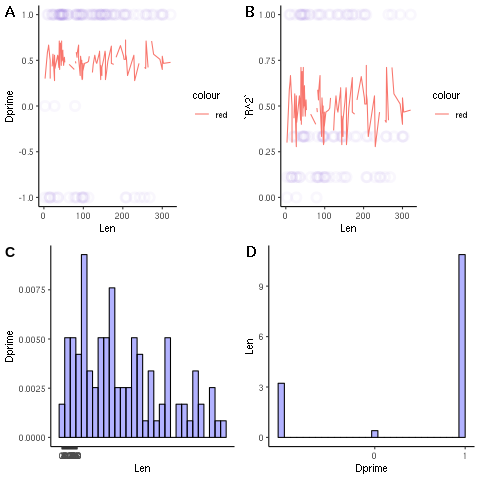

In [33]:
%%R
library(readr)
library(magrittr)
library(dplyr)
library(tidyverse)      # data manipulation and visualization
library(lubridate)      # easily work with dates and times
library(fpp2)           # working with time series data
library(zoo)            # working with time series data
library(ggplot2)
library(ggrepel)
library(ggpubr)

out_vcftools_hap <- read_delim("~/Desktop/Work/Project/Simulation/result/vcftools_out_file_Pleistodontes_nigriventris_CYTB[gene].fasta.aligned.fasta.hap.ld", 
                               "\t", escape_double = FALSE, trim_ws = TRUE)
# View(out_vcftools_hap)

sample <- out_vcftools_hap[sample(nrow(out_vcftools_hap), as.integer(nrow(out_vcftools_hap)/10)), ]

sample <- sample %>% mutate(Len=POS2-POS1) %>%
  mutate(ma = ma(`R^2`, order = as.integer(nrow(sample)/10), centre = TRUE))

# "%+%" <- function(...){
#   paste0(...)
# }

# plot(out_vcftools_hap$Len, out_vcftools_hap$D)
# 
# plot(out_vcftools_hap$Len, out_vcftools_hap$`R^2`)

# x = out_vcftools_hap$Len
# y = out_vcftools_hap$`R^2`

par(mfrow=c(2,2))
theme_set(theme_classic())
a <- ggplot(sample, aes(Len, `Dprime`)) +
  geom_point(size = 3, shape = 21, color = "mediumpurple", alpha = 0.05, stroke = 2)+
  geom_line(aes(Len, ma, colour="red"))


b <- ggplot(sample, aes(Len, `R^2`)) +
  geom_point(size = 3, shape = 21, color = "mediumpurple", alpha = 0.05, stroke = 2)+
  geom_line(aes(Len, ma, colour="red"))



c <- ggplot(sample, aes(Len, `Dprime`)) + 
  geom_histogram(aes(y =..density..), 
                 col="black", 
                 fill="blue", 
                 alpha=.30) + 
  scale_x_continuous(breaks=seq(0,30,1))


d <- ggplot(sample, aes(`Dprime`, Len)) + 
  geom_histogram(aes(y =..density..), 
                 col="black", 
                 fill="blue", 
                 alpha=.30) + 
  scale_x_continuous(breaks=seq(0,30,1))

ggarrange(a, b, c, d,
          labels = c("A", "B", "С", "D"),
          ncol = 2, nrow = 2)


['Pleistodontes_nigriventris_CYTB[gene].fasta.aligned.fasta', 'Chondrocyclus_isipingoensis_CO1[gene].fasta.aligned.fasta', 'Xenophrys_jingdongensis_CO1[gene].fasta.aligned.fasta', 'Darevskia_valentini_CYTB[gene].fasta.aligned.fasta', 'Leucocytozoon_simondi_CYTB[gene].fasta.aligned.fasta', 'Darevskia_portschinskii_CYTB[gene].fasta.aligned.fasta', 'Marcusenius_macrolepidotus_CYTB[gene].fasta.aligned.fasta', 'Acanthodactylus_boskianus_CYTB[gene].fasta.aligned.fasta', 'Squalius_pyrenaicus_CYTB[gene].fasta.aligned.fasta', 'Chondrocyclus_sp._n._7_MC-2018_CO1[gene].fasta.aligned.fasta', 'Anatololacerta_danfordi_danfordi_CYTB[gene].fasta.aligned.fasta', 'Idiosoma_jarrah_CYTB[gene].fasta.aligned.fasta', 'Xenophrys_boettgeri_CYTB[gene].fasta.aligned.fasta', 'Squalius_carolitertii_CYTB[gene].fasta.aligned.fasta', 'Gonionotophis_stenophthalmus_CYTB[gene].fasta.aligned.fasta', 'Tanganicodus_irsacae_CYTB[gene].fasta.aligned.fasta', 'Canis_lupus_familiaris_CYTB[gene].fasta.aligned.fasta', 'Idiosoma_k

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


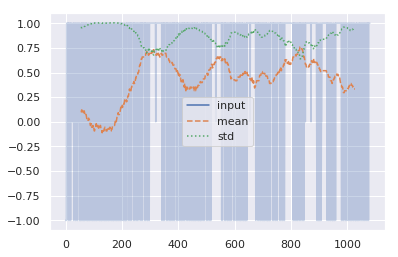

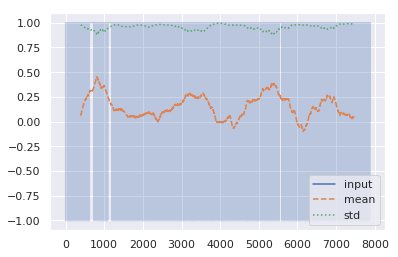

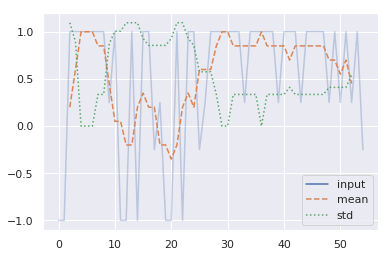

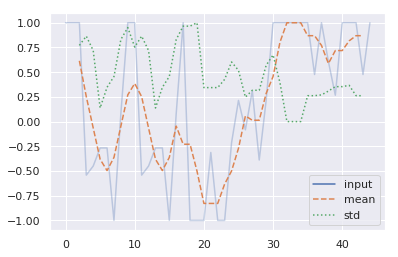

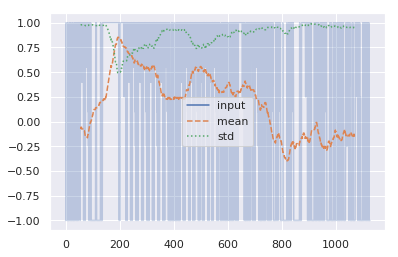

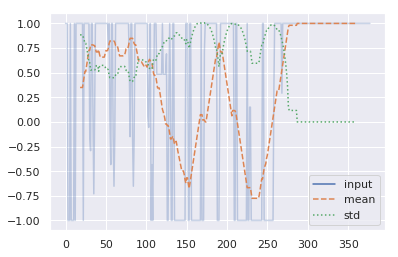

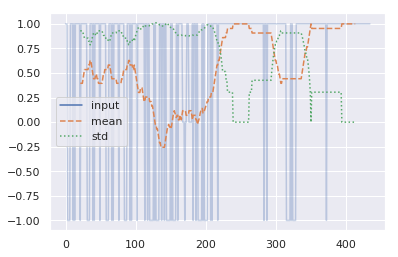

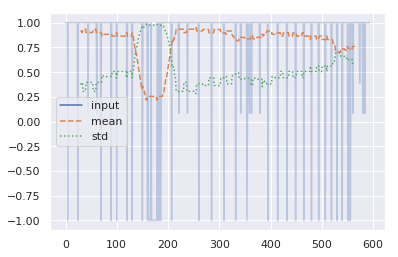

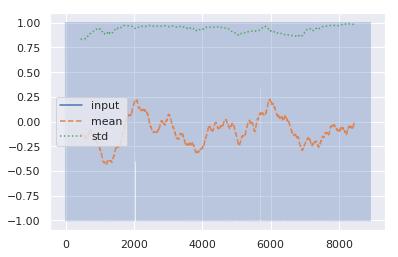

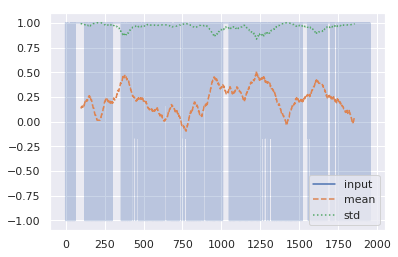

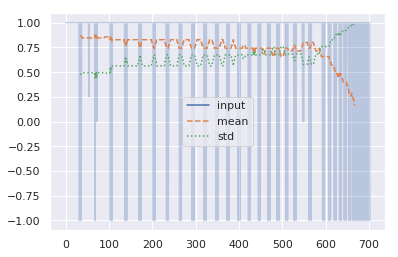

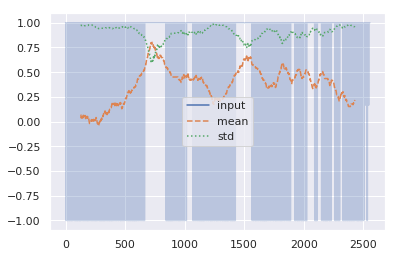

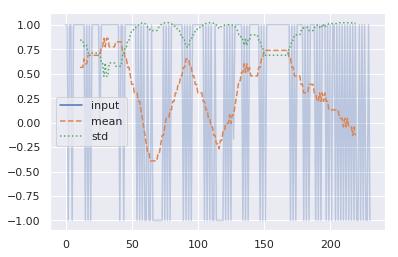

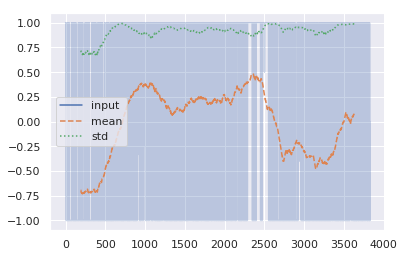

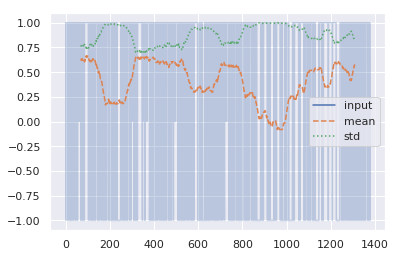

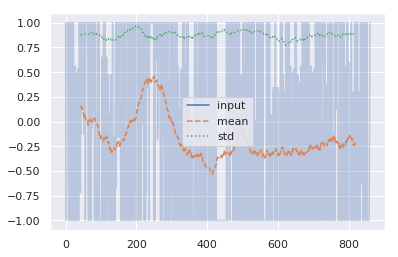

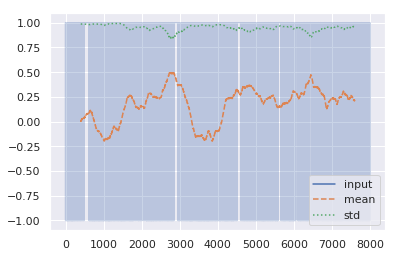

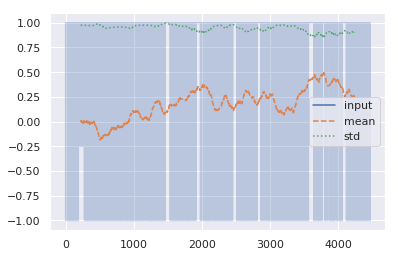

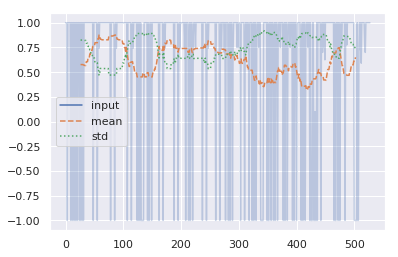

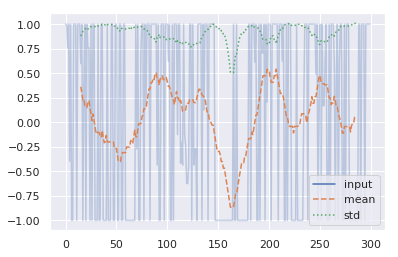

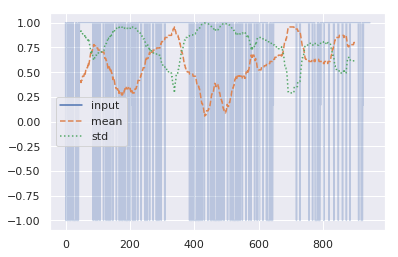

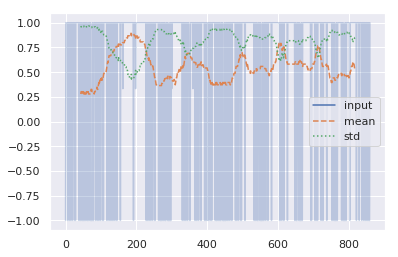

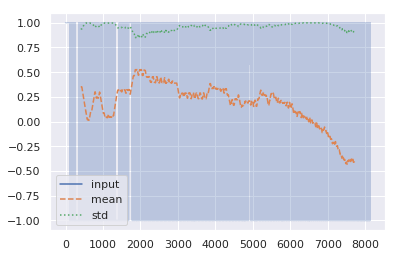

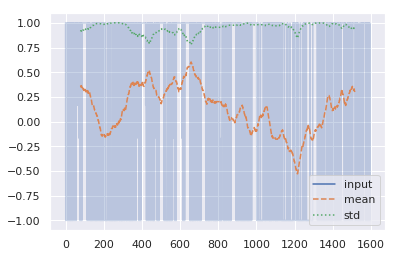

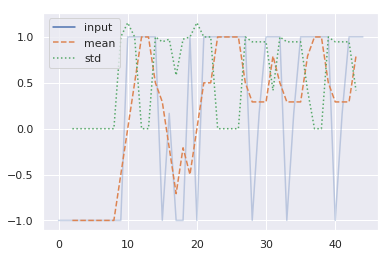

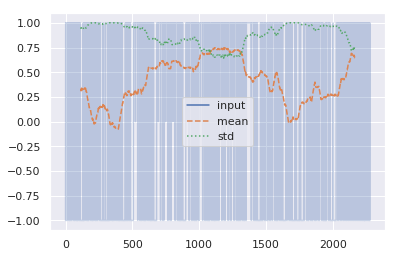

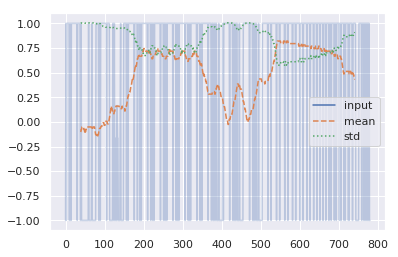

In [32]:
temp_result = [f for f in os.listdir(outputdir) if os.path.splitext(f)[1] == '.fasta']
print(temp_result)

for i in temp_result:
    try:
        line1 = 'snp-sites -mvp -o {out_file} {in_file}'.format(out_file = outputdir + "/snp-sites_out_file_" + str(i),
            in_file = outputdir + "/" + str(i))
        p = subprocess.Popen(line1, shell=True)
        p.wait()
    
        line2 = 'vcftools --hap-r2 --vcf {in_file} --out {out_file}'.format(in_file = outputdir + "/snp-sites_out_file_" + str(i) + ".vcf", 
                out_file = outputdir + "/vcftools_out_file_" + str(i))
        p = subprocess.Popen(line2, shell=True)
        p.wait()
        
        
        df = pd.read_csv(outputdir + "/vcftools_out_file_" + str(i) + ".hap.ld", sep='\t',index_col=False)
        df["Len"] = df["POS2"] - df["POS1"]
        df.head()
    
        goog = df['Dprime']
        rolling = goog.rolling(len(goog)//10, center=True)
        data = pd.DataFrame({'input': goog,'mean': rolling.mean(),'std': rolling.std()})
        ax = data.plot(style=['-', '--', ':'])
        ax.lines[0].set_alpha(0.3)  
        plt.savefig(str(i) + "_dist.png")
        #plt.show()
    
    except FileNotFoundError:
        continue